In [3]:
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt
import cv2 as cv

In [4]:
def non_max_suppression(gradient_magnitude, gradient_direction):
    suppressed_gradient = np.zeros_like(gradient_magnitude)
    
    gradient_direction = (gradient_direction * 180 / np.pi) % 180

    for i in range(1, gradient_magnitude.shape[0] - 1):
        for j in range(1, gradient_magnitude.shape[1] - 1):
            q = 255
            r = 255
            
            if (0 <= gradient_direction[i, j] < 22.5) or (157.5 <= gradient_direction[i, j] <= 180):
                q = gradient_magnitude[i, j + 1]
                r = gradient_magnitude[i, j - 1]
            elif 22.5 <= gradient_direction[i, j] < 67.5:
                q = gradient_magnitude[i + 1, j - 1]
                r = gradient_magnitude[i - 1, j + 1]
            elif 67.5 <= gradient_direction[i, j] < 112.5:
                q = gradient_magnitude[i + 1, j]
                r = gradient_magnitude[i - 1, j]
            elif 112.5 <= gradient_direction[i, j] < 157.5:
                q = gradient_magnitude[i - 1, j - 1]
                r = gradient_magnitude[i + 1, j + 1]

            if (gradient_magnitude[i, j] >= q) and (gradient_magnitude[i, j] >= r):
                suppressed_gradient[i, j] = gradient_magnitude[i, j]
            else:
                suppressed_gradient[i, j] = 0

    return suppressed_gradient

In [5]:
def double_threshold(gradient_image, low_threshold, high_threshold):
    edge_image = np.zeros_like(gradient_image)

    strong_edges = (gradient_image >= high_threshold)
    weak_edges = (gradient_image >= low_threshold) & (gradient_image < high_threshold)
    
    strong_edge_rows, strong_edge_cols = np.nonzero(strong_edges)
    edge_image[strong_edge_rows, strong_edge_cols] = 255

    weak_edge_rows, weak_edge_cols = np.nonzero(weak_edges)
    for i in range(len(weak_edge_rows)):
        row = weak_edge_rows[i]
        col = weak_edge_cols[i]
        neighborhood = gradient_image[row-1:row+2, col-1:col+2]
        if np.max(neighborhood) >= high_threshold:
            edge_image[row, col] = 255

    return edge_image

In [6]:
def canny_edge_detection(image, low_threshold, high_threshold):
    if len(image.shape) == 3:
        image = np.mean(image, axis=-1)
    blurred_image = ndimage.gaussian_filter(image, sigma=1)
    gradient_x = ndimage.sobel(blurred_image, axis=1)
    gradient_y = ndimage.sobel(blurred_image, axis=0)
    gradient_magnitude = np.hypot(gradient_x, gradient_y)
    gradient_direction = np.arctan2(gradient_y, gradient_x)

    suppressed_gradient = non_max_suppression(gradient_magnitude, gradient_direction)

    edge_image = double_threshold(suppressed_gradient, low_threshold, high_threshold)

    return edge_image

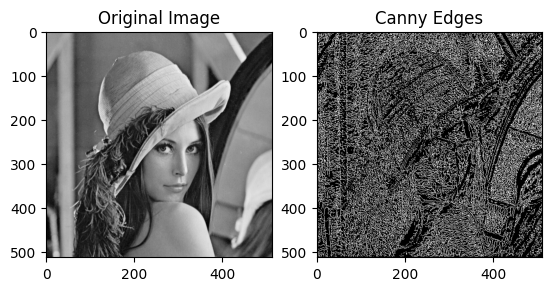

In [7]:
img = cv.imread('CoverImages/lena.tiff',0)
edges_result = canny_edge_detection(img, 30, 100)

# Display the original image and the edges
plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(edges_result, cmap='gray')
plt.title('Canny Edges')

plt.show()

In [8]:
import numpy as np


def gaussian_kernel(size, sigma=1):
    size = int(size) // 2
    x, y = np.mgrid[-size:size+1, -size:size+1]
    normal = 1 / (2.0 * np.pi * sigma**2)
    g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
    return g

In [9]:
from scipy import ndimage

def sobel_filters(img):
    Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
    Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)
    
    Ix = ndimage.filters.convolve(img, Kx)
    Iy = ndimage.filters.convolve(img, Ky)
    
    G = np.hypot(Ix, Iy)
    G = G / G.max() * 255
    theta = np.arctan2(Iy, Ix)
    
    return (G, theta)

In [10]:
def non_max_suppression(img, D):
    M, N = img.shape
    Z = np.zeros((M,N), dtype=np.int32)
    angle = D * 180. / np.pi
    angle[angle < 0] += 180

    
    for i in range(1,M-1):
        for j in range(1,N-1):
            try:
                q = 255
                r = 255
                
               #angle 0
                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    q = img[i, j+1]
                    r = img[i, j-1]
                #angle 45
                elif (22.5 <= angle[i,j] < 67.5):
                    q = img[i+1, j-1]
                    r = img[i-1, j+1]
                #angle 90
                elif (67.5 <= angle[i,j] < 112.5):
                    q = img[i+1, j]
                    r = img[i-1, j]
                #angle 135
                elif (112.5 <= angle[i,j] < 157.5):
                    q = img[i-1, j-1]
                    r = img[i+1, j+1]

                if (img[i,j] >= q) and (img[i,j] >= r):
                    Z[i,j] = img[i,j]
                else:
                    Z[i,j] = 0

            except IndexError as e:
                pass
    
    return Z

In [11]:
def threshold(img, lowThresholdRatio=0.05, highThresholdRatio=0.09):
    
    highThreshold = img.max() * highThresholdRatio;
    lowThreshold = highThreshold * lowThresholdRatio;
    
    M, N = img.shape
    res = np.zeros((M,N), dtype=np.int32)
    
    weak = np.int32(25)
    strong = np.int32(255)
    
    strong_i, strong_j = np.where(img >= highThreshold)
    zeros_i, zeros_j = np.where(img < lowThreshold)
    
    weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))
    
    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak
    
    return (res, weak, strong)

In [12]:
def hysteresis(img, weak, strong=255):
    M, N = img.shape  
    for i in range(1, M-1):
        for j in range(1, N-1):
            if (img[i,j] == weak):
                try:
                    if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                        or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                        or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                        img[i, j] = strong
                    else:
                        img[i, j] = 0
                except IndexError as e:
                    pass
    return img